# <a class="anchor" id="1.5_bullet" style="color:#581908"> **Model training and registration** </a>
---

In this notebook we will:

- Register a model to the model registry.
- Fetch the model from the model registry.

This will introduce the `hsml` (**H**opsworks **M**achine **L**earning) library, which contains functionality to keep track of models and deploy them.

*Note: you need to enable Serving to run this notebook. Go to the **old** Hopsworks UI, click on settings, and check the Serving box.*

In [1]:
import hsfs

conn = hsfs.connection()
fs = conn.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


### <a class="anchor" id="1.5_bullet" style="color:#3772ff"> **⬇️ Training Dataset retrieval** </a>

To retrieve training dataset from **Feature Store** we retrieve **Feature View** using `FeatureStore.get_feature_view` method.

Then we can use **Feature View** in order to retrieve **training dataset** using `FeatureView.get_training_dataset` method.


In [2]:
nyc_fares_fv = fs.get_feature_view(
    name = 'nyc_taxi_fares',
    version = 1
)

In [3]:
X_train, y_train, X_test, y_test = nyc_fares_fv.get_train_test_split(
    training_dataset_version=2
)

In [4]:
cols_to_drop = ['pickup_datetime', 'ride_id', 'pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

In [5]:
X_train = X_train.drop(cols_to_drop, axis = 1)
X_test = X_test.drop(cols_to_drop, axis = 1)

In [6]:
X_test

,month_of_the_ride,passenger_count,distance,pickup_distance_to_jfk,dropoff_distance_to_jfk,pickup_distance_to_ewr,dropoff_distance_to_ewr,pickup_distance_to_lgr,dropoff_distance_to_lgr,year,weekday,hour
0,202001,2,4.542561,8.207207,9.342458,13.795003,11.818338,5.463683,9.971459,2020,4,0
1,202001,2,2.950174,8.228490,8.942018,14.093878,16.018538,4.956796,2.125818,2020,2,18
2,202001,2,14.859294,14.947669,8.544431,12.282407,15.215420,17.975351,3.224295,2020,4,14
3,202001,2,6.288258,8.707592,8.877166,12.342885,15.901979,8.426007,2.277260,2020,3,0
4,202001,2,1.427555,8.290212,8.210910,14.442159,13.605922,4.392554,5.796770,2020,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...
8100,202001,3,9.338248,17.425403,10.181697,25.742470,17.849300,9.929153,1.059557,2020,1,18
8101,202001,3,0.620122,18.065918,17.515357,26.391734,25.833782,10.648220,10.030527,2020,0,7
8102,202001,3,11.403952,18.649614,9.787991,26.981436,17.321485,11.298100,0.916293,2020,1,4
8103,202001,3,7.371391,19.179963,12.904201,27.515560,21.027758,11.884404,4.569731,2020,2,23


In [7]:
y_test

,total_fare
0,7.0
1,8.0
2,8.0
3,10.0
4,12.0
...,...
8100,123.0
8101,129.0
8102,133.0
8103,139.0


In [8]:
import numpy as np


y_train, y_test = np.ravel(y_train), np.ravel(y_test)

In [9]:
y_test

array([  7.,   8.,   8., ..., 133., 139., 143.])

## 🤖 **Model Building**

### <a class="anchor" id="1.5_bullet" style="color:#e363a3"> **📝 Importing Libraries** </a>

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score

## <a class="anchor" id="1.5_bullet" style="color:#df2935"> **🧬 Modeling** </a>

### Lets use [Weights and Biases](https://wandb.ai/) for hyperparameter tuning

### <a class="anchor" id="1.5_bullet" style="color:#df2935"> **🔬 Random Forest Regressor** </a>


In [11]:
# !pip install wandb

In [12]:
import wandb
wandb.login()

wandb: Currently logged in as: rktraz_. Use `wandb login --relogin` to force relogin


True

In [13]:
def train_model():
  # Set default configurations (Defaults will be overwritten during sweep)
  config_defaults = {
      'max_depth': 3, 
      'n_estimators': 50
  }

  # Start W&B
  wandb.init(config=config_defaults)
  config = wandb.config

  # Fit regression model on train set
  model = RandomForestRegressor(
      max_depth=config.max_depth,
      n_estimators=config.n_estimators
  )
  model.fit(X_train, y_train)

  # Predict on test set
  y_preds = model.predict(X_test)
  
  # Evaluate predictions
  mae_score = mean_absolute_error(y_test, y_preds)
  r2 = r2_score(y_test, y_preds)
  print(f"MAE: {round(mae_score, 4)}, R²: {round(r2, 2)}")

  # Log model performance metrics to W&B
  wandb.log({"mae": mae_score, "r2_score": r2})

In [14]:
sweep_configs = {
    "method": "random",
    "metric": {
        "name": "mae",
        "goal": "minimize"
    },
    "parameters": {
        "max_depth": {
            "values": [4, 6, 8, 10]
        },
        "n_estimators": {
            "values": [200, 350, 500, 800, 1000]
        }
    }
}

In [15]:
sweep_id = wandb.sweep(sweep=sweep_configs, project="my-test-project")

Create sweep with ID: 5s2eeqps
Sweep URL: https://wandb.ai/rktraz_/my-test-project/sweeps/5s2eeqps


In [16]:
wandb.agent(sweep_id=sweep_id, function=train_model, count=5)

2022-07-28 17:06:27,025 INFO: Starting sweep agent: entity=None, project=None, count=5


wandb: Agent Starting Run: iaducu1t with config:
wandb: 	max_depth: 8
wandb: 	n_estimators: 200


MAE: 8.3051, R2: 0.77


mae,▁
r2_score,▁
mae,8.30512
r2_score,0.77046


wandb: Agent Starting Run: 11hlnele with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 200


MAE: 7.9957, R2: 0.78


mae,▁
r2_score,▁
mae,7.99574
r2_score,0.78051


wandb: Agent Starting Run: b4x7n0y1 with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 200


MAE: 7.9862, R2: 0.78


mae,▁
r2_score,▁
mae,7.98619
r2_score,0.78121


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x7e5tl8a with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 500


MAE: 7.9929, R2: 0.78


mae,▁
r2_score,▁
mae,7.99293
r2_score,0.78044


wandb: Agent Starting Run: 5arltwpp with config:
wandb: 	max_depth: 10
wandb: 	n_estimators: 800


MAE: 7.9707, R2: 0.78


mae,▁
r2_score,▁
mae,7.97066
r2_score,0.78174


### Now on WandB site we can see plots with our results (MAE and R^2 metrics per iteration)

![image.png](images/mae_graph.png)

### Here we can see all our iterations with different hyperparameters, and, as we can see, the best ones are:

- `max_depth=10`
- `n_estimators=800`

![image.png](images/table_wandb.png)

In [17]:
rf_model = RandomForestRegressor(
    max_depth=10,
    n_estimators=800,
    n_jobs = -1,
    random_state = 42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [18]:
rf_preds = rf_model.predict(X_test)

rf_r2_score = r2_score(y_test, rf_preds)
rf_mae = mean_absolute_error(y_test, rf_preds)

print("Random Forest Regressor R²:", rf_r2_score)
print("Random Forest Regressor MAE:", rf_mae)

Random Forest Regressor R²: 0.7811858125451058
Random Forest Regressor MAE: 7.9788410044294364


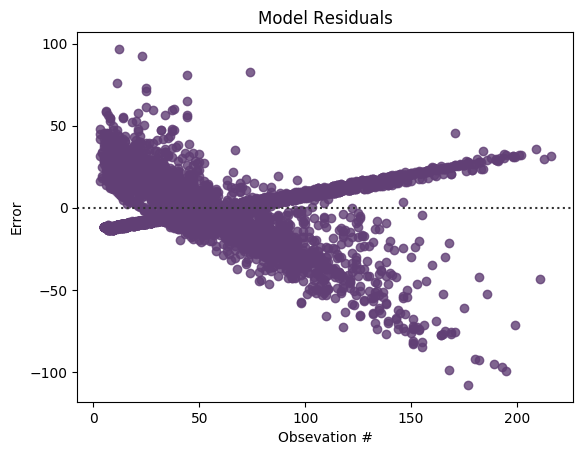

In [19]:
sns.residplot(y_test, rf_preds, color='#613F75')
plt.title('Model Residuals')
plt.xlabel('Obsevation #')
plt.ylabel('Error')

plt.show()

The Random Forest did a better job, so we will register this specififc model.

## <a class="anchor" id="1.5_bullet" style="color:#525252"> **📝 Register model** </a>


One of the features in Hopsworks is the model registry. This is where we can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

Let's connect to the model registry using the [HSML library](https://docs.hopsworks.ai/machine-learning-api/latest) from Hopsworks.

In [20]:
import hsml

conn = hsml.connection()
mr = conn.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


Before registering the model we will export it as a pickle file using joblib.

In [21]:
import joblib

joblib.dump(rf_model, 'model.pkl')

['model.pkl']

### <a class="anchor" id="1.5_bullet" style="color:#525252"> **Model Schema** </a>


The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [22]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

model_schema.to_dict()

{'input_schema': {'columnar_schema': [{'name': 'month_of_the_ride',
    'type': 'int64'},
   {'name': 'passenger_count', 'type': 'int64'},
   {'name': 'distance', 'type': 'float64'},
   {'name': 'pickup_distance_to_jfk', 'type': 'float64'},
   {'name': 'dropoff_distance_to_jfk', 'type': 'float64'},
   {'name': 'pickup_distance_to_ewr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_ewr', 'type': 'float64'},
   {'name': 'pickup_distance_to_lgr', 'type': 'float64'},
   {'name': 'dropoff_distance_to_lgr', 'type': 'float64'},
   {'name': 'year', 'type': 'int64'},
   {'name': 'weekday', 'type': 'int64'},
   {'name': 'hour', 'type': 'int64'}]},
 'output_schema': {'tensor_schema': {'shape': '(32802,)', 'type': 'float64'}}}

With the schema in place, we can finally register our model.

In [23]:
metrics = {
    'mae': rf_mae,
    'r2_score': rf_r2_score
}


In [24]:
model = mr.sklearn.create_model(
    name="nyc_taxi_fares_model",
    metrics=metrics,
    description="Random Forest Regressor.",
    input_example=X_train.sample(),
    model_schema=model_schema
)

model.save('model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://0219e3d0-0dbb-11ed-a194-61e8c4026c40.cloud.hopsworks.ai/p/119/models/nyc_taxi_fares_model/2


Model(name: 'nyc_taxi_fares_model', version: 2)

Here we have also saved an input example from the training data, which can be helpful for test purposes.

It's important to know that every time you save a model with the same name, a new version of the model will be saved, so nothing will be overwritten. In this way, you can compare several versions of the same model - or create a model with a new name, if you prefer that.

In [25]:
model = mr.get_model("nyc_taxi_fares_model", version = 1)

## <a class="anchor" id="1.5_bullet" style="color:#ff5f27"> **🚀 Model Deployment** </a>

In [26]:
%%writefile predict_example.py
import os
import hsfs
import joblib
import numpy as np
import pandas as pd

class Predict(object):

    def __init__(self):
        """ Initializes the serving state, reads a trained model"""        
        # get feature store handle
        fs_conn = hsfs.connection()
        self.fs = fs_conn.get_feature_store()
        
        # load the trained model
        self.model = joblib.load(os.environ["ARTIFACT_FILES_PATH"] + "/model.pkl")
        print("Initialization Complete")

    def predict(self, inputs):
        """ Serves a prediction request usign a trained model"""
        return self.model.predict(np.array(inputs).reshape(1, -1)).tolist()

Writing predict_example.py


In [ ]:
# I have created this file manually cause it was not creating by itself

In [27]:
predictor_script_path = f'hdfs:///Projects/{fs.project_name}/Jupyter/predict_example.py'

In [28]:
# Give it any name you want
deployment = model.deploy(
    name="nyctaxifares", 
    model_server="PYTHON",
    script_file=predictor_script_path,
    serving_tool = "KSERVE"
)

Deployment created, explore it at https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/deployments/2067
Before making predictions, start the deployment by using `.start()`


In [29]:
print("Deployment: " + deployment.name)
deployment.describe()

Deployment: nyctaxifares
{
    "artifact_version": 1,
    "batching_configuration": {
        "batching_enabled": false
    },
    "created": "2022-07-28T09:47:30.678Z",
    "creator": "Roman Kaharlytskyi",
    "id": 2067,
    "inference_logging": "NONE",
    "model_name": "nyc_taxi_fares_model",
    "model_path": "/Projects/tutorials_testing/Models/nyc_taxi_fares_model",
    "model_server": "PYTHON",
    "model_version": 1,
    "name": "nyctaxifares",
    "predictor": "predict_example.py",
    "predictor_resources": {
        "limits": {
            "cores": 1,
            "gpus": 0,
            "memory": 1024
        },
        "requests": {
            "cores": 1,
            "gpus": 0,
            "memory": 1024
        }
    },
    "requested_instances": 1,
    "serving_tool": "KSERVE"
}


### The deployment has now been registered. However, to start it you need to run:

In [30]:
deployment.start()

  0%|          | 0/1 [00:00<?, ?it/s]

Start making predictions by using `.predict()`


In [31]:
deployment.get_logs()

Explore all the logs and filters in the Kibana logs at https://0f060790-06a4-11ed-8aed-d1422d4ec537.cloud.hopsworks.ai/p/2170/deployments/2067

Instance name: nyctaxifares-predictor-default-00001-deployment-c5cbfb4df-lv54r
[I 220728 09:47:55 kserve-component-server:95] Initializing predictor for deployment: nyctaxifares
[I 220728 09:47:56 kfserver:150] Registering model: nyctaxifares
[I 220728 09:47:56 kfserver:120] Setting asyncio max_workers as 5
[I 220728 09:47:56 kfserver:127] Listening on port 8080
[I 220728 09:47:56 kfserver:129] Will fork 1 workers




---
## <span style='color:#ff5f27'>🔮 Predicting</span>

In [32]:
model.input_example

[202001.0,
 2.0,
 1.5703191792504667,
 8.968786831126206,
 9.709475070370804,
 16.066152859109724,
 17.212637732135967,
 2.065254190970983,
 0.9497771793041722,
 2020.0,
 1.0,
 9.0]

In [33]:
data = {
    "inputs": model.input_example
}

deployment.predict(data)

{'predictions': [33.34]}

In [34]:
deployment.stop()

  0%|          | 0/1 [00:00<?, ?it/s]